# Install Dependencies

In [48]:
!pip install sklearn
!pip install matplotlib
!pip install scrapy

!pip install fastText
!pip install spacy
!pip install nltk
!pip install tensorflow
!pip install tensorflow_hub
!python -m spacy download en_core_web_md


    Linking successful
    /anaconda3/lib/python3.6/site-packages/en_core_web_md -->
    /anaconda3/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



# Import Dependencies

In [23]:
import numpy as np
import pickle
import csv
import json
import re
import math
from pprint import pprint

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import nltk
from nltk.corpus import stopwords
import fastText
import spacy
import tensorflow as tf
import tensorflow_hub as hub

import logging
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.selector import Selector
from urllib.parse import urljoin

In [11]:
# Settings for notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Show Python version
import platform
platform.python_version()

'3.6.5'

# Crawling Data

## Get Offenders Info

### Setup a pipeline

In [12]:
class OffenderInfoWriterPipeline(object):
    def open_spider(self, spider):
        self.file = open('data/offender_info_results.json', 'w+')
    def close_spider(self, spider):
        self.file.close()
    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

### Define the spider

In [13]:
class OffenderInfoSpider(scrapy.Spider):
    name = "OffenderInfo"
    start_urls = [
        'http://www.tdcj.state.tx.us/death_row/dr_executed_offenders.html'
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.OffenderInfoWriterPipeline': 1}
    }

    def parse(self, response):
        print('A response from %s just arrived!', response.url)
        sel = Selector(response)

        table = sel.xpath('//table[@class="tdcj_table indent"]/tr')
        for tr in table[1:]:
            url_info = urljoin(response.url, str(tr.xpath('td[2]/a/@href').extract_first()))
            url_stmt = urljoin(response.url, str(tr.xpath('td[3]/a/@href').extract_first()))
        
            yield {
                'first_name': tr.xpath('td[5]/text()').extract_first(),
                'last_name': tr.xpath('td[4]/text()').extract_first(),
                'age': tr.xpath('td[7]/text()').extract_first(),
                'date': tr.xpath('td[8]/text()').extract_first(),
                'race': tr.xpath('td[9]/text()').extract_first(),
                'country': tr.xpath('td[10]/text()').extract_first(),
                'info_link': url_info,
                'death_note_link': url_stmt
            }
        

### Start the crawler

In [14]:
process = CrawlerProcess()
process.crawl(OffenderInfoSpider)
process.start()

2018-11-25 20:15:11 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-11-25 20:15:11 [scrapy.utils.log] INFO: Versions: lxml 4.2.1.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.1, w3lib 1.19.0, Twisted 18.7.0, Python 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) - [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 18.0.0 (OpenSSL 1.0.2o  27 Mar 2018), cryptography 2.2.2, Platform Darwin-17.7.0-x86_64-i386-64bit
2018-11-25 20:15:11 [scrapy.crawler] INFO: Overridden settings: {'LOG_LEVEL': 30}


A response from %s just arrived! http://www.tdcj.state.tx.us/death_row/dr_executed_offenders.html


In [16]:
file = open('data/offender_info_results.json', 'r')
lines = file.readlines()
line = lines[0]
obj = json.loads(line)
pprint([key for key in obj])

['first_name',
 'last_name',
 'age',
 'date',
 'race',
 'country',
 'info_link',
 'death_note_link']


## Extract Death Note

In [17]:
urls = []
objs = []

file = open('data/offender_info_results.json', 'r')
lines = file.readlines()
for line in lines:
    objs.append(json.loads(line))
    urls.append(objs[-1]['death_note_link'])

### Setup a pipeline

In [18]:
class DeathNoteWriterPipeline(object):
    def open_spider(self, spider):
        self.file = open('data/death_note_results.json', 'w+')
    def close_spider(self, spider):
        self.file.close()
    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item
   

### Define the spider

In [19]:
import logging
from scrapy.selector import Selector

class DeathNoteSpider(scrapy.Spider):
    name = "DeathNote"
    start_urls = urls
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.DeathNoteWriterPipeline': 1}
    }

    def parse(self, response):     
        sel = Selector(response)
    
        first = str(sel.xpath('//div[@id="content_right"]/p[6]/text()').extract_first()).strip()
        second = str(sel.xpath('//div[@id="content_right"]/p[7]/text()').extract_first()).strip()
        
        death_note = ''
        if first and first != 'Last Statement:' and first != 'None':
            death_note += first
        if second and second != 'None':
            death_note += second
            
        url = response.url
        obj = [o for o in objs if o['death_note_link'] == url][0]
        obj['death_note'] = death_note
    
        yield obj

### Start the crawler

In [21]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})
process.crawl(DeathNoteSpider())
process.start()

2018-11-25 20:15:41 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-11-25 20:15:41 [scrapy.utils.log] INFO: Versions: lxml 4.2.1.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.1, w3lib 1.19.0, Twisted 18.7.0, Python 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) - [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 18.0.0 (OpenSSL 1.0.2o  27 Mar 2018), cryptography 2.2.2, Platform Darwin-17.7.0-x86_64-i386-64bit
2018-11-25 20:15:41 [scrapy.crawler] INFO: Overridden settings: {'LOG_LEVEL': 30, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


ReactorNotRestartable: 

# Data Cleaning

In [22]:
file = open('data/death_note_results.json', 'r')
lines = file.readlines()
objs = []
for line in lines:
    objs.append(json.loads(line))

## String Format Converting

In [23]:
for i in range(len(objs)):
    note = objs[i]['death_note']
    if len(note.strip()) > 0:
        note = (note.encode('ascii', 'ignore')).decode("utf-8")
        objs[i]['death_note'] = note

## Remove Punctuations and Stopwords

In [24]:
stop_words = set(stopwords.words('english')) - set('not')
rm_punc = re.compile('[^a-zA-Z]')

In [25]:
objs_clean = []
death_notes_clean = []
for i in range(len(objs)):
    note = objs[i]['death_note']
    note = rm_punc.sub(' ', note)
    words = []
    tokens = note.split()
    for token in tokens:
        if token and token not in stop_words and token.lower() not in stop_words \
        and token.lower() != 'none':
            words.append(token)
    
    if words:
        note = ' '.join(words)
        death_notes_clean.append(note)
        objs[i]['death_note'] = note
        objs_clean.append(objs[i])

In [13]:
with open('data/death_notes_clean.pickle', 'wb') as handle:
    pickle.dump(objs_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('data/death_notes_clean.pickle', 'rb') as handle:
    death_notes_clean = pickle.load(handle)

In [9]:
death_notes_clean

[{'first_name': 'Christopher',
  'last_name': 'Young',
  'age': '34',
  'date': '7/17/2018',
  'race': 'Black',
  'country': 'Bexar',
  'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/youngchristopher.html',
  'death_note_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/youngchristopherlast.html',
  'death_note': 'l want make sure Patel family knows love like love Make sure kids world know Im executed kids Ive mentoring keep fight going Im good Warden'},
 {'first_name': 'Daniel',
  'last_name': 'Acker',
  'age': '46',
  'date': '9/27/2018',
  'race': 'White',
  'country': 'Hopkins',
  'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/ackerdaniel.html',
  'death_note_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/ackerdaniellast.html',
  'death_note': 'statement given'},
 {'first_name': 'Troy',
  'last_name': 'Clark',
  'age': '51',
  'date': '9/26/2018',
  'race': 'White',
  'country': 'Smith',
  'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_i

In [10]:
len(death_notes_clean)

449

## Lemmatization

In [15]:
nlp = spacy.load('en_core_web_lg')

In [16]:
def clean(text):
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    return ' '.join(tokens)

In [17]:
objs_lemma = []
death_notes_lemma = []
for i in range(len(objs_clean)):
    obj = objs_clean[i]
    
    note = clean(obj['death_note'])
    death_notes_lemma.append(note)
    obj['death_note'] = note
    objs_lemma.append(obj)

In [21]:
len(death_notes_lemma)

449

In [18]:
with open('data/death_notes_lemma.pickle', 'wb') as handle:
    pickle.dump(objs_lemma, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('data/death_notes_lemma.pickle', 'rb') as handle:
    death_notes_lemma = pickle.load(handle)

In [14]:
death_notes_lemma[0]['death_note']

'l want make sure patel family know love like love make sure kid world know be execute kid have mentor keep fight go be good warden'

## Bag-of-Words

In [16]:
#per doc
bag_of_words = {}
statement_word_count = {}
for s_id in range(len(death_notes_lemma)):
    words_list = death_notes_lemma[s_id]['death_note'].split()
    statement_word_count[s_id] = len(words_list)
    bag_of_words[s_id] = {}
    for word in words_list:
        if word in bag_of_words[s_id]:
            bag_of_words[s_id][word] = bag_of_words[s_id][word] +1
        else:
            bag_of_words[s_id][word] = 1

for s_id in bag_of_words:
    sorted_x = dict(sorted(bag_of_words[s_id].items(), key=lambda kv: kv[1], reverse=True))
    bag_of_words[s_id] = sorted_x

In [17]:
# for all doc
statementFreqDict = {}

for s_id in bag_of_words:
    for word in bag_of_words[s_id]:
        if word in statementFreqDict:
            statementFreqDict[word] = statementFreqDict[word] + bag_of_words[s_id][word]
        else:
            statementFreqDict[word] = bag_of_words[s_id][word]
        
sorted_x = dict(sorted(statementFreqDict.items(), key=lambda kv: kv[1], reverse=True))
statementFreqDict = sorted_x


## Claculating TFIDF

In [25]:
def tf(ngram, doc_id, ngram_count, ngramDocDict):
    return ngramDocDict[doc_id][ngram] / ngram_count[doc_id]

def n_containing(ngram, ngramDocDict):
    return sum(1 for doc_id in ngramDocDict if ngram in ngramDocDict[doc_id])

def idf(ngram, ngramDocDict):
    return math.log(len(ngramDocDict) / (n_containing(ngram, ngramDocDict)))

def tfidf(ngram, doc_id, ngram_count, ngramDocDict):
    return tf(ngram, doc_id, ngram_count, ngramDocDict) * idf(ngram, ngramDocDict)

In [26]:
def cal_tfidf_doc(ngramDocDict):
    
    ngram_statement_tfidf = {}
    for s_id in ngramDocDict:
        ngram_statement_tfidf[s_id] = {}

        for ngram in ngramDocDict[s_id]:
            ngram_statement_tfidf[s_id][ngram] = tfidf(ngram, s_id, statement_word_count, ngramDocDict)
            
    return ngram_statement_tfidf

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
 
def tfidf_encoding(ls):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ls)
    tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)
    return X_train_tf

In [ ]:
statement_tfidf = cal_tfidf_doc(bag_of_words)

## Printing top 10 TFIDF

In [29]:
from heapq import heappush, heappop

heap = []

for s_id in statement_tfidf:
    for word in statement_tfidf[s_id]:
        heappush(heap, (statement_tfidf[s_id][word], word))
        
        if len(heap) > 10:
            heappop(heap)

In [30]:
while(heap):
    r = heappop(heap)
    print(r[1], r[0])

see 1.542674696274418
fo 1.7448636822120727
peace 1.830356768726199
ji 2.0356742959140846
santajaib 2.0356742959140846
singh 2.0356742959140846
bye 2.0805563693434705
final 2.0805563693434705
release 2.248792487654077
israel 3.0535114438711273


# Word Embedding

In [64]:
death_notes = death_notes_lemma
#death_notes = death_notes_clean

## Using TFIDF 

## FastText

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

last_words = []
for s_id in range(len(death_notes)):
    last_words.append(death_notes_lemma[s_id]['death_note'])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(last_words)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(449, 2643)

In [122]:
X_train_tfidf

<449x2643 sparse matrix of type '<class 'numpy.float64'>'
	with 14326 stored elements in Compressed Sparse Row format>

## Google W2V

In [31]:
#loading Google_news model
from gensim.models import KeyedVectors
filename = '/Users/biksingh/Natural_Language_Generation/Sprint5_Integrate_ngram_to_embedding/GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)
vocab = google_model.vocab.keys()

In [51]:
google_embedding_avg = [] 
google_embedding_tfidf = []
word_vect_list = [] # list storing only vectors of the words
word_not_vocab = [] # list storing words which are nt in the Google news vocab

for s_id in range(len(death_notes_lemma)): 
    words_list = death_notes_lemma[s_id]['death_note'].split()
    vec = 0
    count = 0
    vec_tfidf = 0
    tfidf_total = 0
    for word in words_list:
        if word in vocab:
            vec = vec + google_model[word]
            vec_tfidf += google_model[word] * statement_tfidf[s_id][word]
            tfidf_total += statement_tfidf[s_id][word]
            count += 1
        else:
            word_not_vocab.append(word)
    google_embedding_avg.append(vec/count)
    google_embedding_tfidf.append(vec_tfidf/tfidf_total)

In [148]:
embed_file = "data/google_avg_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(google_embedding_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [149]:
embed_file = "data/google_weighted_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(google_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Glove Embedding

In [36]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/Users/biksingh/Natural_Language_Generation/Sprint5_Integrate_ngram_to_embedding/glove.6B.300d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

glove_vocab = glove_model.vocab.keys()

In [54]:
glove_embedding_avg = [] #list to store words and their corresponding vectors
glove_embedding_tfidf = []
word_not_vocab_glove = [] # list storing words which are nt in the Google news vocab


for s_id in range(len(death_notes_lemma)): 
    words_list = death_notes_lemma[s_id]['death_note'].split()
    vec = 0
    count = 0
    vec_tfidf = 0
    tfidf_total = 0
    for word in words_list:
        if word in glove_vocab:
            vec = vec + glove_model[word]
            vec_tfidf += glove_model[word] * statement_tfidf[s_id][word]
            tfidf_total += statement_tfidf[s_id][word]
            count += 1
        else:
            word_not_vocab_glove.append(word)
    glove_embedding_avg.append(vec/count)
    glove_embedding_tfidf.append(vec_tfidf/tfidf_total)

In [151]:
embed_file = "data/glove_avg_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(glove_embedding_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [150]:
embed_file = "data/glove_weighted_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(glove_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## FastText

In [42]:
fasttext_model = fastText.load_model('/Users/biksingh/Natural_Language_Generation/Sprint6_rare_in_clusters/crawl-300d-2M-subword.bin')

In [45]:
#sentence
fasttext_embedding = []
for s_id in range(len(death_notes_lemma)):  
    fasttext_embedding.append(fasttext_model.get_sentence_vector(death_notes_lemma[s_id]['death_note']))

In [152]:
embed_file = "data/fastText_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(fasttext_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
from nltk.tokenize import word_tokenize

ft_embedding_avg = [] #dictionary to store words and their corresponding vectors
ft_embedding_tfidf = {}

for s_id in range(len(death_notes_lemma)):
    vec = 0
    c = 0
    vec_tfidf = 0
    tfidf_total = 0
    for word in word_tokenize(death_notes_lemma[s_id]['death_note']):
        vec = vec + fasttext_model.get_word_vector(word)
        vec_tfidf = vec_tfidf + fasttext_model.get_word_vector(word) * statement_tfidf[s_id][word]
        tfidf_total += statement_tfidf[s_id][word]
        c = c + 1
    ft_embedding_avg.append(vec/c)
    ft_embedding_tfidf.append(vec_tfidf/tfidf_total)


In [153]:
embed_file = "data/ft_avg_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(ft_embedding_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [154]:
embed_file = "data/ft_weighted_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(ft_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Spacy

In [55]:
nlp_md = spacy.load('en_core_web_md')
spacy_embedding = []
for s_id in range(len(death_notes_lemma)): 
    doc = nlp_md(death_notes_lemma[s_id]['death_note'])
    spacy_embedding.append(doc.vector)

In [155]:
embed_file = "data/spacy_avg_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(spacy_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# weighted average
spacy_embedding_tfidf = []

for s_id in range(len(death_notes_lemma)): 
    words_list = death_notes_lemma[s_id]['death_note'].split()
    vec_tfidf_spacy = 0
    tfidf_total = 0
    for word in words_list:
        doc = nlp_md(word)
        vec_tfidf_spacy += doc.vector * statement_tfidf[s_id][word]
        tfidf_total += statement_tfidf[s_id][word]
        spacy_embedding_tfidf.append(vec_tfidf_spacy/tfidf_total)



In [156]:
embed_file = "data/spacy_weighted_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(spacy_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Universal Sentence Encoder

In [ ]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
use_model = hub.Module(use_url)

In [ ]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    use_embedding = session.run(use_model(death_notes))

In [ ]:
embed_file = "data/use_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(use_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Elmo

In [ ]:
elmo_url = "https://tfhub.dev/google/elmo/2"
elmo_model = hub.Module(elmo_url)

In [19]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    elmo_embedding = session.run(elmo_model(death_notes))

In [ ]:
embed_file = "data/elmo_embedding.pickle"
with open(embed_file, 'wb') as handle:
    pickle.dump(elmo_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Clustering

In [182]:
embedding = X_train_tfidf
#embedding = google_embedding_avg
# embedding = google_embedding_tfidf
# embedding = glove_embedding_avg
# embedding = glove_embedding_tfidf
# embedding = spacy_embedding
# embedding = spacy_embedding_tfidf
# embedding = ft_embedding
# embedding = ft_embedding_avg
# embedding = ft_embedding_tfidf
# embedding = use_embedding
# embedding = elmo_embedding

In [183]:
np.matrix(X_train_tfidf).shape

(1, 1)

In [140]:
#embedding.shape

AttributeError: 'list' object has no attribute 'shape'

In [141]:
print(np.array(embedding).shape)

(449, 300)


## Elbow Method

ValueError: setting an array element with a sequence.

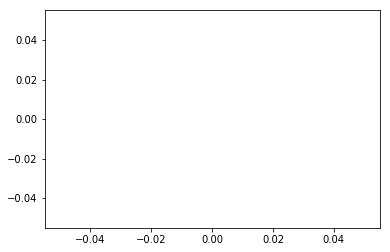

In [181]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

maximum = 25

_ = plt.plot()
distortions = []
K = range(2, maximum+1)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=2018)
    _ = kmeans.fit(embedding)
    _ = distortions.append(kmeans.inertia_)

# Plot the elbow
_ = plt.plot(K, distortions, 'bx-')
_ = plt.xlabel('k')
_ = plt.ylabel('Distortion')
_ = plt.title('The Elbow Method showing the optimal k')
plt.show()

## K-Mean

In [174]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=2018).fit(embedding)
clusters = kmeans.predict(embedding)

## Get notes in each clsuter

In [136]:
note_clusters = {}
for c in set(clusters):
    note_clusters[c] = []
    for i, txt in enumerate(death_notes):
        if clusters[i] == c:
            note_clusters[c].append(txt)

In [137]:
(note_clusters)

{0: [{'first_name': 'Daniel',
   'last_name': 'Acker',
   'age': '46',
   'date': '9/27/2018',
   'race': 'White',
   'country': 'Hopkins',
   'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/ackerdaniel.html',
   'death_note_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/ackerdaniellast.html',
   'death_note': 'statement give'},
  {'first_name': 'Tommy',
   'last_name': 'Sells',
   'age': '49',
   'date': '04/03/2014',
   'race': 'White',
   'country': 'Val Verde',
   'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/sellstommy.html',
   'death_note_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/sellstommylast.html',
   'death_note': 'offender decline make last statement'},
  {'first_name': 'Jose',
   'last_name': 'Villegas',
   'age': '39',
   'date': '04/16/2014',
   'race': 'Hispanic',
   'country': 'Nueces',
   'info_link': 'http://www.tdcj.state.tx.us/death_row/dr_info/villegasjose.html',
   'death_note_link': 'http://www.tdcj.state.tx.us/death_

# Results Analysis

## Clustering Visualization

In [175]:
arr = np.array(embedding)
tsne = TSNE(n_components=2, random_state=2018)
reduced = tsne.fit_transform(arr)       
t = np.array(reduced).transpose()

TypeError: float() argument must be a string or a number, not 'coo_matrix'

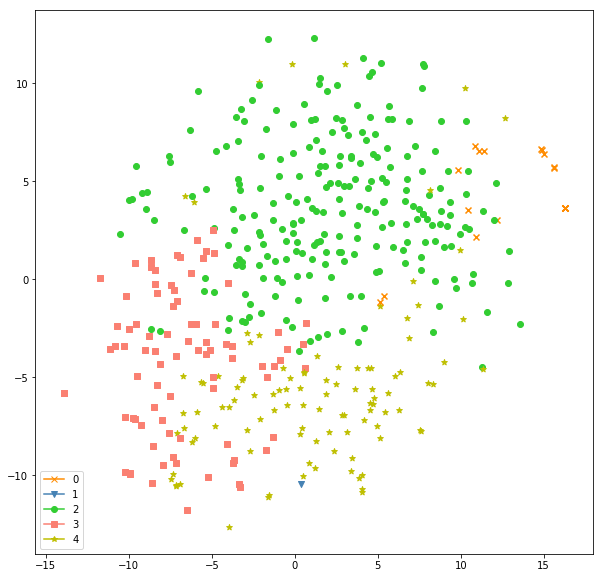

In [145]:
from matplotlib.lines import Line2D

markers = ["x", "v", "o", "s", "*", ">", "<", "P", 
           '1', '2', '3', '4', 'h', "d", "|", "+"]
colors = ['darkorange', 'steelblue', 'limegreen',  'salmon', 'y',  'violet', 'c', 'tomato', 
          'rosybrown', 'brown', 'darkmagenta', 'pink', 'gold', "orange", "skyblue", "seagreen"]

fig, ax = plt.subplots(figsize=(10, 10))

for x, y, c in zip(t[0], t[1], clusters):
    _ = ax.scatter(x, y, c=colors[c], marker=markers[c])

types = []
for c in set(clusters):
    types.append(Line2D([], [], color=colors[c], marker=markers[c], label=c))

# for i, c in enumerate(clusters):
#     if c == 5:
#         _ = ax.annotate(doc_txt[i], (t[0][i], t[1][i]), fontsize=18)

_ = plt.legend(handles=types, loc='lower left')
plt.show()

In [146]:
for i in range(len(clusters)):
    if clusters[i] == 3:
        print(death_notes_ori[i])
        print()

NameError: name 'death_notes_ori' is not defined

## Top 10 words in each cluster

In [ ]:
#per doc within cluster
bag_of_words = {}

for c_id in range(len(note_clusters)):
    bag_of_words[c_id] = {}
    
    for s_id in range(len(note_clusters[c_id])):
        words_list = note_clusters[c_id][s_id]['death_note'].split()
        bag_of_words[c_id][s_id] = {}
        for word in words_list:
            if word in bag_of_words[c_id][s_id]:
                bag_of_words[c_id][s_id][word] = bag_of_words[c_id][s_id][word] +1
            else:
                bag_of_words[c_id][s_id][word] = 1

for c_id in bag_of_words:
    for s_id in bag_of_words[c_id]:
        sorted_x = dict(sorted(bag_of_words[c_id][s_id].items(), key=lambda kv: kv[1], reverse=True))
        bag_of_words[c_id][s_id] = sorted_x

In [ ]:
# for all doc within each cluster

statementFreqDict = {}

for c_id in bag_of_words:
    statementFreqDict[c_id] = {}
    for s_id in bag_of_words[c_id]:
        for word in bag_of_words[c_id][s_id]:
            if word in statementFreqDict[c_id]:
                statementFreqDict[c_id][word] = statementFreqDict[c_id][word] + bag_of_words[c_id][s_id][word]
            else:
                statementFreqDict[c_id][word] = bag_of_words[c_id][s_id][word]

for c_id in bag_of_words:
    sorted_x = dict(sorted(statementFreqDict[c_id].items(), key=lambda kv: kv[1], reverse=True))
    statementFreqDict[c_id] = sorted_x

In [147]:
statementFreqDict

{0: {'statement': 14,
  'last': 8,
  'make': 7,
  'offender': 6,
  'decline': 6,
  'ready': 5,
  'warden': 3,
  'release': 3,
  'give': 2,
  'write': 2,
  'final': 2,
  'case': 2,
  'error': 2,
  'free': 2,
  'word': 2,
  'be': 2,
  'speak': 1,
  'mic': 1,
  'ever': 1,
  'try': 1,
  'may': 1,
  'proceed': 1,
  'profanity': 1,
  'direct': 1,
  'toward': 1,
  'staff': 1,
  'blessing': 1,
  'bring': 1,
  'execute': 1,
  'speech': 1,
  'that': 1,
  's': 1,
  'prepare': 1,
  'chaplain': 1,
  'want': 1,
  'medium': 1,
  'high': 1,
  'flight': 1,
  'aviation': 1,
  'poem': 1},
 1: {'santajaib': 1, 'singh': 1, 'ji': 1},
 2: {'love': 422,
  'family': 249,
  'know': 247,
  'sorry': 186,
  'would': 180,
  'say': 175,
  'want': 168,
  'like': 168,
  'go': 159,
  'thank': 144,
  't': 136,
  'get': 120,
  'one': 116,
  'hope': 111,
  'people': 107,
  'life': 106,
  'take': 105,
  'god': 97,
  'do': 85,
  'give': 84,
  'forgive': 84,
  'tell': 84,
  'death': 77,
  'see': 75,
  'peace': 75,
  'make': 